# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import numpy as np
import sweetviz as sv
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
def plot_numeric(df, variable, title, xlabel, bins):
    '''Рисует графики распределения количественных переменных'''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    f.suptitle(title, fontsize=20)
    ax1.boxplot(df[variable])
    ax1.set_title('Ящик с усами')
    ax1.set_xlabel(xlabel)
    ax1.set_xticks([])

    ax2.hist(df[variable], bins=bins)
    ax2.set_title('Гистограмма')
    ax2.set_xlabel(xlabel)

    plt.show()

In [5]:
df = pd.read_csv('/datasets/autos.csv')

## Исследовательский анализ данных

<a href='https://k8s.jupyterhub.praktikum-services.ru/user/user-0-122161133/view/eda.html'>Посмотреть EDA отчет</a>

### Промежуточный вывод

1. Подозрительно выглядят цены и мощности двигателя равные нулям. Стоит исплючить их из датасета. Мы не хотим прогнозировать бесплатные автомобили.
2. 11% пропусков в VehicleType можно заменить на (Other)
3. В годах выпуска присутствуют аномалии - слишком маленькие (1000) и слишком большие (6500) значения. Стоит избавиться от них, оставив наиболее часто встречающиеся > 1900 и < 2020, поскольку год выпуска автомобиля довольно сильно связан со стоимостью на него
4. Колонка Repaired содержит много пропущенных значений - 20%. Не очень понятно, что значит эта колонка. Любая машина когда-то была в ремонте, но плановый ремонт и ремонт после ДТП - это не одно и то же
5. LastSeen, DateCrawled, RegistrationMonth, NumberOfPictures, DateCreated - неинформативные признаки. PostalCode тоже сомнительно информативен. В теории, в разных городах цены на авто могут незначительно различаться, но с другой стороны учет этого признака может внести больше шума, чем пользы.

In [8]:
# Удаляем неинформативные признаки
df = df.drop(
    [
        'LastSeen',
        'DateCrawled',
        'RegistrationMonth',
        'NumberOfPictures',
        'PostalCode',
        'DateCreated',
    ],
    axis=1,
)
display(df.head())
df.shape

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


(354369, 10)

In [9]:
# Удаляем нулевые цены
df = df[df['Price'] > 0]
display(df.head())
df.shape

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


(343597, 10)

Посмотрим на мощности внимательнее.

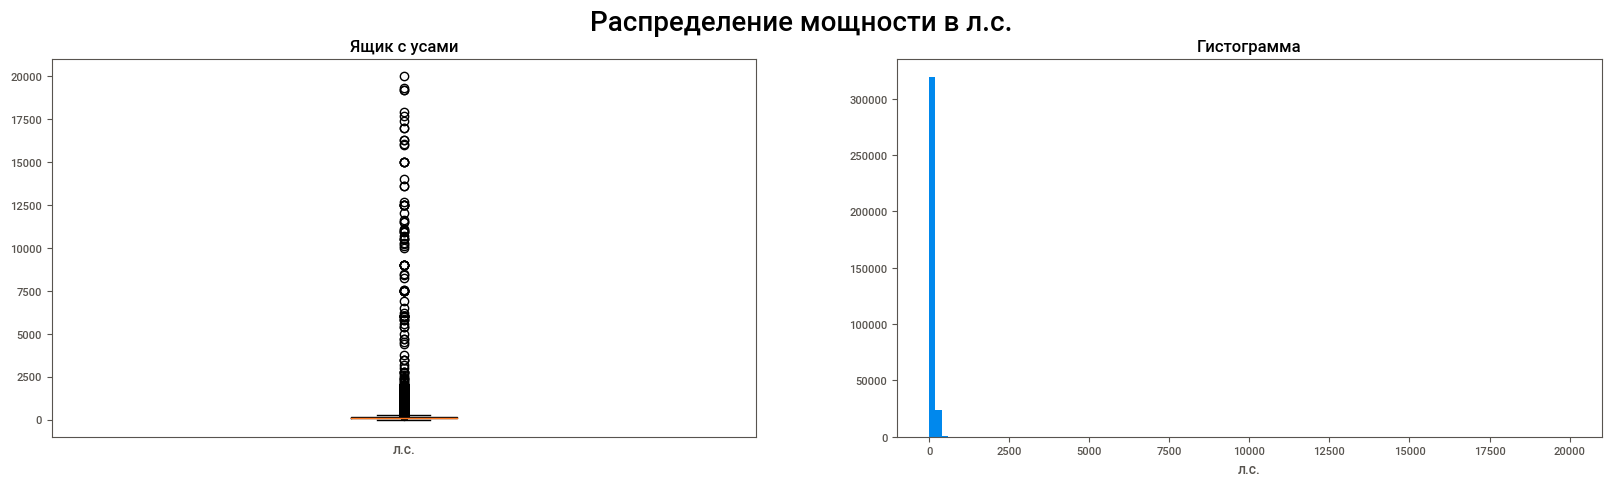

In [10]:
plot_numeric(df, 'Power', 'Распределение мощности в л.с.', 'л.с.', 100)

В датасете большое количество выбросов. Поскольку нас интересуют автомобили, установим верхнюю границу датасет в 225 л.с., а нижнюю в 71 л.с.

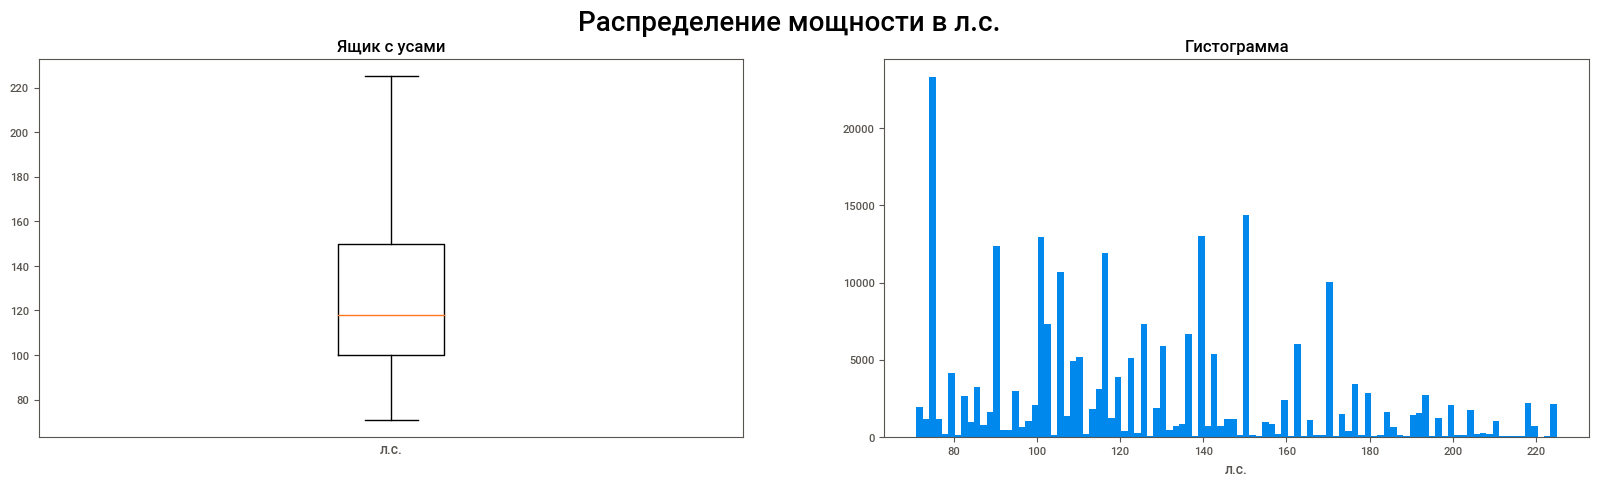

In [11]:
plot_numeric(
    df[(df['Power'] <= 225) & (df['Power'] >= 71)],
    'Power',
    'Распределение мощности в л.с.',
    'л.с.',
    100,
)

In [12]:
# Удаляем нулевые мощности
df = df[(df['Power'] <= 225) & (df['Power'] >= 71)]
display(df.head())
df.shape

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


(242122, 10)

In [13]:
# Удаляем аномальные года регистрации
df = df[(df['RegistrationYear'] > 1930) & (df['RegistrationYear'] <= 2016)]

df = df.reset_index(drop=True)
display(df.head())
df.shape

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


(234189, 10)

## Подготовка данных

In [14]:
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, test_size=TEST_SIZE
)

In [15]:
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
num_cols = ['RegistrationYear', 'Power', 'Kilometer']

oe_processor = Pipeline(
    # Обработка категориальных признаков
    [
        (
            'imputer',
            SimpleImputer(
                missing_values=np.nan,
                strategy='constant',
                fill_value='unknown',
            ),
        ),
        (
            'encoder',
            OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=-1
            ),
        ),
    ]
)

data_preprocessor = ColumnTransformer(
    # Пайплайн обработки
    [('cat', oe_processor, cat_cols), ('num', StandardScaler(), num_cols)],
    remainder='passthrough',
)

pipe_final = Pipeline(
    # Финальный пайплайн
    [('preprocessor', data_preprocessor), ('model', lgb.LGBMRegressor())]
)

Нам нужно создать метрику rmse, чтобы оценить её на кросс-валидации

In [16]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance**2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score


rmse_score = make_scorer(rmse, greater_is_better=False)

In [17]:
# Параметры LGBM регрессии
lgbm_params = {}

lgbm_params['model__n_estimators'] = [1000, 20000]
lgbm_params['model__max_depth'] = [10, 5000]
lgbm_params['model'] = [
    lgb.LGBMRegressor(random_state=RANDOM_STATE, metric='rmse')
]

# Параметры дерева решений

tree_params = {}

tree_params['model__max_depth'] = [2]
tree_params['model__min_samples_split'] = [500, 1000]
tree_params['model'] = [DecisionTreeRegressor()]

params = [tree_params, lgbm_params]

In [18]:
grid_reg = GridSearchCV(
    pipe_final, params, cv=5, scoring=rmse_score, n_jobs=-1
)

In [19]:
grid_reg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired...
                                                                          'Kilometer'])])),
                                       ('model', LGBMRegressor())]),
             n_jobs=-1,
             param_grid=[{'model': [DecisionTreeRegressor()],
                          'model__max_depth': [2],
                          'model__min_samples_split': [500, 1000]},
                         {'model': [LGBMRegressor(metric='rmse',
                                                  random_state=42)],
                          'model__max_depth': [10, 5000],
                          'model__n_estimators': [1000, 20000]}],
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

## Обучение моделей

In [20]:
# Сохраним лучшую модель в отдельную переменную
lgbreg = grid_reg.best_estimator_.steps[1][1]
treereg = DecisionTreeRegressor()

In [21]:
# Узнаем её RMSE
grid_reg.best_score_ * -1

1528.5215654300696

In [22]:
# Сохраним преобразованные данные в отдельные переменные,
# чтобы вычислить время обучения моделей без учета преобразования
X_train_prepared = data_preprocessor.fit_transform(X_train)
X_test_prepared = data_preprocessor.transform(X_test)

Пора узнать время обучения и предсказания моделей.

In [23]:
%%time
# LGBM - время обучения
lgbreg.fit(X_train_prepared, y_train)

CPU times: user 34.3 s, sys: 190 ms, total: 34.5 s
Wall time: 34.7 s


LGBMRegressor(max_depth=5000, metric='rmse', n_estimators=1000, random_state=42)

In [24]:
%%time
# Дерево решений - время обучения
treereg.fit(X_train_prepared, y_train)

CPU times: user 593 ms, sys: 250 µs, total: 594 ms
Wall time: 638 ms


DecisionTreeRegressor()

## Анализ моделей

In [25]:
%%time
# LGBM - время предсказания
lgb_pred = lgbreg.predict(X_train_prepared)

CPU times: user 15.1 s, sys: 11 ms, total: 15.1 s
Wall time: 15.1 s


In [26]:
%%time
# Дерево решений - время предсказания
tree_pred = treereg.predict(X_train_prepared)

CPU times: user 71.8 ms, sys: 36 µs, total: 71.8 ms
Wall time: 113 ms


In [27]:
results_df_reg = pd.DataFrame(grid_reg.cv_results_)
results_df_reg = results_df_reg.sort_values(by=["rank_test_score"])
results_df_reg = results_df_reg.set_index(
    results_df_reg["params"].apply(
        lambda x: "_".join(str(val) for val in x.values())
    )
).rename_axis("kernel")
results_df_reg['mean_test_score'] *= -1
results_df_reg[
    ["params", "rank_test_score", "mean_test_score", "std_test_score"]
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
"LGBMRegressor(metric='rmse', random_state=42)_5000_1000","{'model': LGBMRegressor(metric='rmse', random_...",1,1528.521565,18.608103
"LGBMRegressor(metric='rmse', random_state=42)_10_1000","{'model': LGBMRegressor(metric='rmse', random_...",2,1530.548084,17.977037
"LGBMRegressor(metric='rmse', random_state=42)_5000_20000","{'model': LGBMRegressor(metric='rmse', random_...",3,1559.750305,16.734459
"LGBMRegressor(metric='rmse', random_state=42)_10_20000","{'model': LGBMRegressor(metric='rmse', random_...",4,1563.820482,14.513966
DecisionTreeRegressor()_2_500,"{'model': DecisionTreeRegressor(), 'model__max...",5,3178.092116,15.689932
DecisionTreeRegressor()_2_1000,"{'model': DecisionTreeRegressor(), 'model__max...",5,3178.092116,15.689932


## Лучшая модель

Градиентный бустинг хоть и обучается сильно дольше, показывает лучший результат RMSE. Выбираем эту модель и проверим её на тестовой выборке.

In [28]:
y_test_pred = lgbreg.predict(X_test_prepared)

In [29]:
# RMSE на тестовой выборке
mean_squared_error(y_test, y_test_pred) ** 0.5

1522.0793305378

## Общий вывод

**Перед нами стояла задача:**

- Разработать модель, которая бы предсказывала стоимость автомобиля;

**Что мы сделали:**

- Загрузили и обработали данные: проверили наличие дублей и пропущенных значений;
- Провели исследовательский анализ данных: посмотрели, как распределяются переменные в разных разрезах;
- Избавились от неинформативных переменных и строках, которые вносят шум;
- Создали пайплайн, заполняющий пропуски в данных и кодирующий переменные;
- Протестировали две модели - дерево решений и градиентный бустинг, оценив время выполнения и RMSE;

**Результат:**
- Градиентный бустинг обучается и предсказывает в несколько десятков раз медленнее
- Предсказания градиентного бустинга значительно более точные. При целевом значении RMSE = 2500, метрика градиентного бустинга получилась около 1500, а у дерева решений - чуть больше 1900;